In [1]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.base import clone

import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
import utils.ssvep_analysis as sa

In [2]:
def read_data(file_path):
    df = pd.read_csv(file_path, skiprows=10, header=None)
    with open(file_path, 'r') as file:
        content = file.read()
    match = re.search(r'Severity:\s*(\d+(\.\d+)?)', content)
    severity = float(match.group(1))
    eeg_data = df.to_numpy()[:, 1:9].astype(float)
    marker = df.to_numpy()[:, -1].flatten()
    return eeg_data, marker, severity

def preprocess_data(eeg_data, marker):
    eeg_data = sa.apply_ransac_detrending(eeg_data,)
    eeg_data = sa.filter_extreme_values(eeg_data)
    eeg_data = sa.apply_lowpass_filter(eeg_data)
    eeg_data = sa.apply_highpass_filter(eeg_data)
    eeg_data = sa.apply_notch_filter(eeg_data)

    cca_r_values = {}
    for distinct_marker in np.unique(marker):
        cca, target = sa.compute_cca(eeg_data[marker == distinct_marker])
        x, y = cca.transform(eeg_data[marker == distinct_marker], target)
        r = np.corrcoef(x.T, y.T)[0, 1]
        cca_r_values[distinct_marker] = r

    return cca_r_values

def build_dataset(directory_list):
    data_set = []
    for idx, directory in enumerate(directory_list):
        for file in os.listdir('../data/' + directory):
            file_path = '../data/' + directory + '/' + file
            eeg_data, marker, severity = read_data(file_path)
            measurement = preprocess_data(eeg_data, marker)
            measurement['group'] = idx
            measurement['severity'] = severity
            data_set.append(measurement)
    return pd.DataFrame(data_set)


directory_list = ['2024-01-12', '2024-01-19', '2024-01-22']

df = build_dataset(directory_list)
df

,deuteranomaly-1-0.25,deuteranomaly-1-1,deuteranomaly-3-0.25,deuteranomaly-3-1,grey,group,severity
0,0.375574,0.245373,0.447648,0.401223,0.051983,0,0.00
1,0.365784,0.370528,0.457377,0.448240,0.085176,0,0.00
2,0.287945,0.325593,0.495948,0.272126,0.103918,0,0.00
3,0.339754,0.338859,0.387298,0.257413,0.087179,0,0.00
4,0.231315,0.432507,0.449124,0.377003,0.113989,0,0.00
...,...,...,...,...,...,...,...
87,0.141512,0.231912,0.186017,0.263154,0.119034,2,0.82
88,0.193491,0.255700,0.165443,0.255053,0.079774,2,0.83
89,0.184553,0.149915,0.169509,0.236808,0.125487,2,0.86
90,0.134224,0.206987,0.141477,0.172650,0.091619,2,0.87


In [3]:
X = df.dropna().drop(columns=['group', 'severity'])
y = np.where(df.dropna()['severity'] > 0, 1, 0)
groups = df.dropna()['group']

In [4]:
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(X, y, groups, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=42)),
    ('log_reg', LogisticRegression(max_iter=1000, random_state=42))
])

cv = LeaveOneGroupOut()
cv_scores = cross_val_score(pipeline, X_train, y_train, groups=groups_train, cv=cv)
print(f'Cross-validation accuracies: {cv_scores}')
print(f'Mean cross-validation accuracy: {cv_scores.mean():.2%}')

Cross-validation accuracies: [1.   0.84 0.76]
Mean cross-validation accuracy: 86.67%


Test accuracy: 100.00%
AUC ROC: 1.00


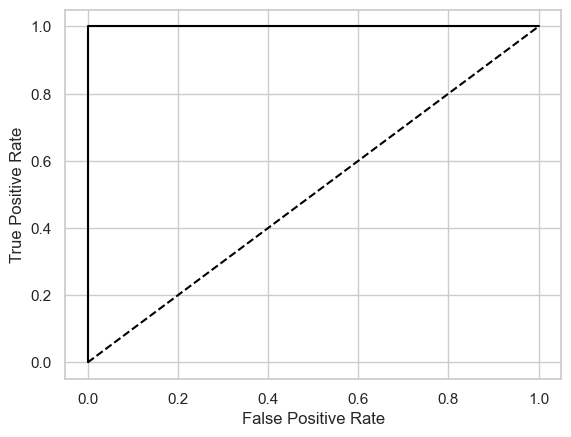

In [5]:
pipeline.fit(X_train, y_train)

print(f'Test accuracy: {pipeline.score(X_test, y_test):.2%}')

y_pred_proba = pipeline.predict_proba(X_test)
auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f'AUC ROC: {auc_roc:.2f}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

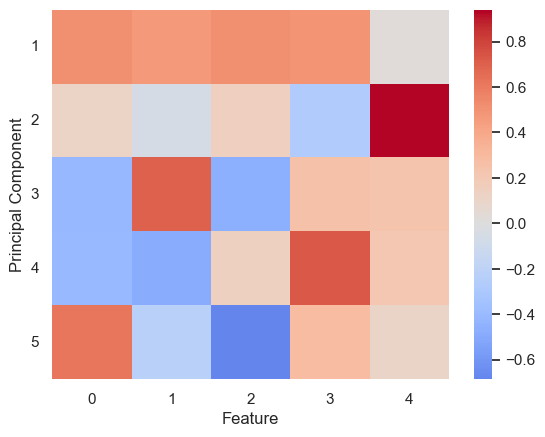

Regression = -2.50 * PC1 + 0.35 * PC2 + 0.55 * PC3 + 1.21 * PC4 + 0.15 * PC5 + -0.30


In [6]:
pca = pipeline.named_steps['pca']

principal_components = pca.components_
sns.heatmap(principal_components, cmap='coolwarm', center=0)
plt.yticks(np.arange(0, len(principal_components))+0.5, range(1, len(principal_components) + 1), rotation=0)
plt.xlabel('Feature')
plt.ylabel('Principal Component')
plt.show()

regression_coefficients = pipeline.named_steps['log_reg'].coef_
regression_intercept = pipeline.named_steps['log_reg'].intercept_

print(f'Regression = {" + ".join([f"{coefficient:.2f} * PC{idx+1}" for idx, coefficient in enumerate(regression_coefficients[0])])} + {regression_intercept[0]:.2f}')

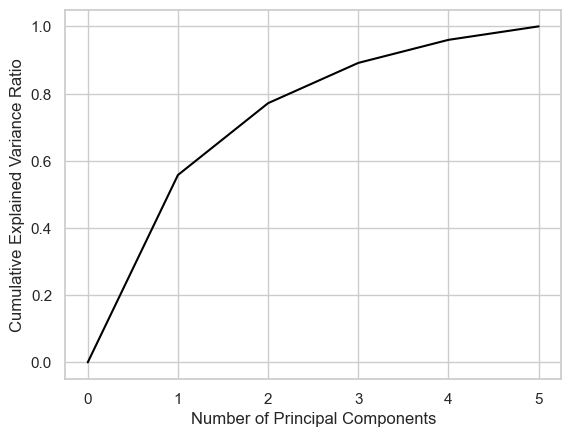

In [7]:
cumulative_explained_variance_ratio = np.concatenate((np.zeros(1), pca.explained_variance_ratio_)).cumsum()
num_components = len(cumulative_explained_variance_ratio)
plt.plot(range(0, num_components), cumulative_explained_variance_ratio, color='black')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

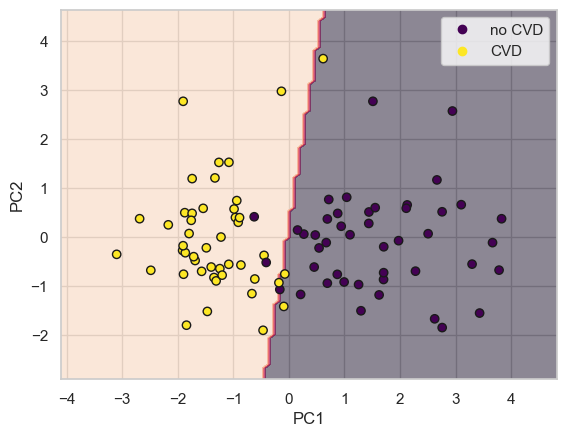

In [8]:
X_reduced = pipeline.named_steps['scaler'].transform(X)
X_reduced = pipeline.named_steps['pca'].transform(X_reduced)
X_reduced = X_reduced[:,:2]

model = clone(pipeline.named_steps['log_reg'])
model.fit(X_reduced, y)
disp = DecisionBoundaryDisplay.from_estimator(
    model, X_reduced, response_method="predict",
    xlabel='PC1', ylabel='PC2',
    alpha=0.5,
)
scatter = disp.ax_.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', cmap='viridis')
disp.ax_.legend(handles=scatter.legend_elements()[0], labels=['no CVD', 'CVD']);

In [9]:
df.describe()

,deuteranomaly-1-0.25,deuteranomaly-1-1,deuteranomaly-3-0.25,deuteranomaly-3-1,grey,group,severity
count,91.000000,92.000000,91.000000,92.000000,92.000000,92.000000,92.000000
mean,0.221621,0.265526,0.250808,0.265567,0.096001,1.000000,0.397826
std,0.072933,0.084649,0.114775,0.086994,0.022719,0.811998,0.406161
min,0.110926,0.096008,0.068023,0.096517,0.051983,0.000000,0.000000
25%,0.163672,0.203239,0.168965,0.191677,0.079558,0.000000,0.000000
50%,0.196101,0.250583,0.205738,0.260284,0.093139,1.000000,0.305000
75%,0.264447,0.327890,0.350153,0.329660,0.108220,2.000000,0.820000
max,0.403983,0.453268,0.534088,0.482138,0.177499,2.000000,0.990000


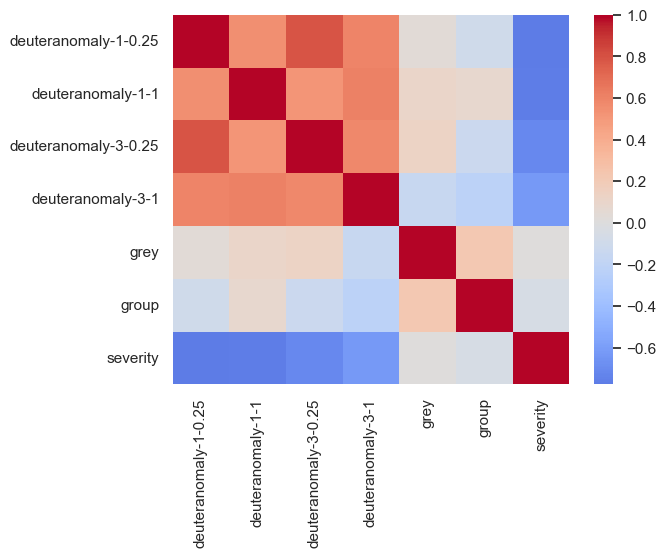

In [10]:
sns.heatmap(df.corr(), cmap='coolwarm', center=0);

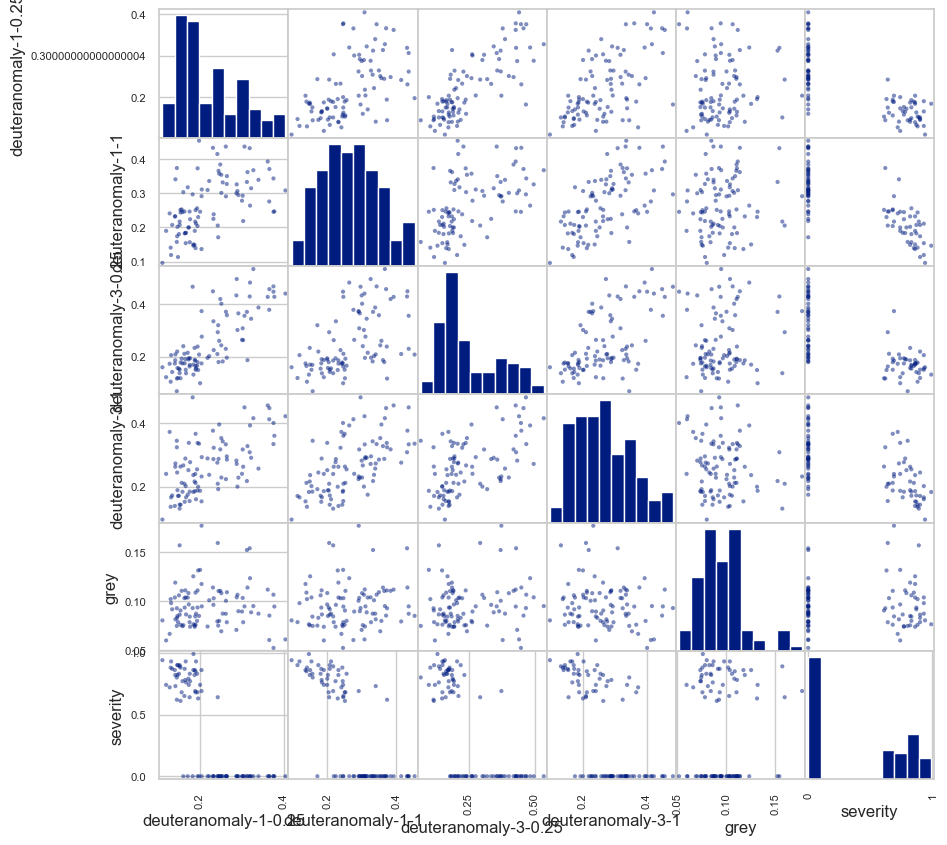

In [11]:
pd.plotting.scatter_matrix(df.drop(columns='group'), figsize=(10, 10));